In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import holidays

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from scipy import stats
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics



# Parcing data

In [2]:
# парсинг ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [3]:
# Преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)

# Перенаименование столбцов
df.columns = ['date', 'key_rate']

In [4]:
# Общая информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2649 entries, 0 to 2648
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2649 non-null   datetime64[ns]
 1   key_rate  2649 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 41.5 KB


In [5]:
# Основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2649.000000
mean,8.746602
std,3.209233
min,4.250000
25%,7.000000
50%,7.750000
75%,10.500000
max,20.000000


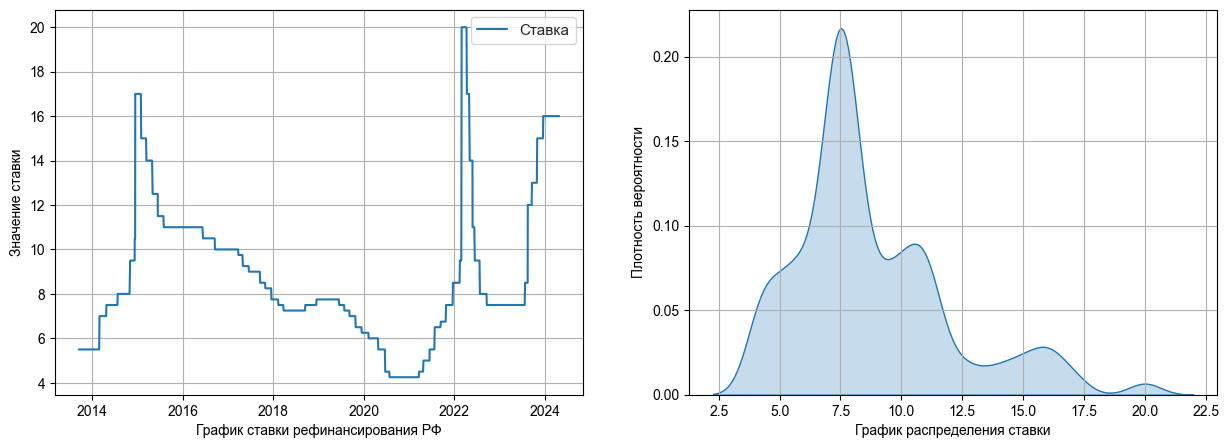

In [7]:
# Смотрим график курса ключевой ствки ЦБ РФ и график распределения
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [8]:
# Проверка на нормальное или ненормальное распределение.
test_shapiro = stats.shapiro(df['key_rate'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.9033232927322388, pvalue=4.906933558758841e-38)
Распределение не нормальное


In [9]:
def create_features(data, col_datetime):
    """Создание сезонов и дней недели"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
    
    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

df_features = create_features(data=df, col_datetime='date')

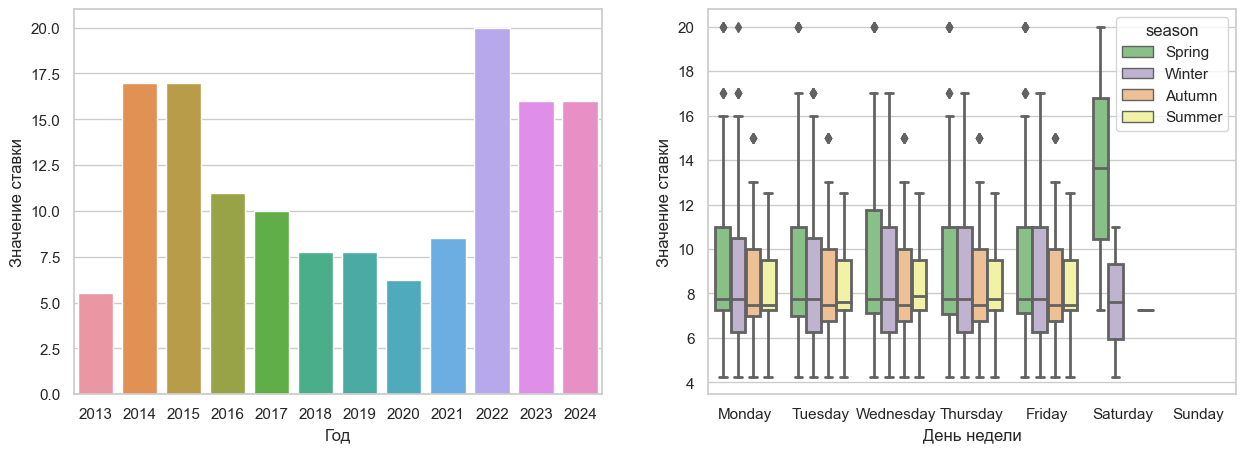

In [10]:
# Смотрим графики для анализа
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=axes[0])
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=axes[1], linewidth=2)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Значение ставки')

plt.show()



In [11]:
# дропаем редкие субботние ключевые ставки
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

In [12]:
# перенаименование названия колонок для prophet
df.columns = ['ds', 'y']

# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)


In [13]:
# сортируем данные по возрастанию для корректного отображения разделения графика
df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [14]:
# разделение данных на train, test
df_train = df[:-pred_days]
df_test = df[-pred_days:]


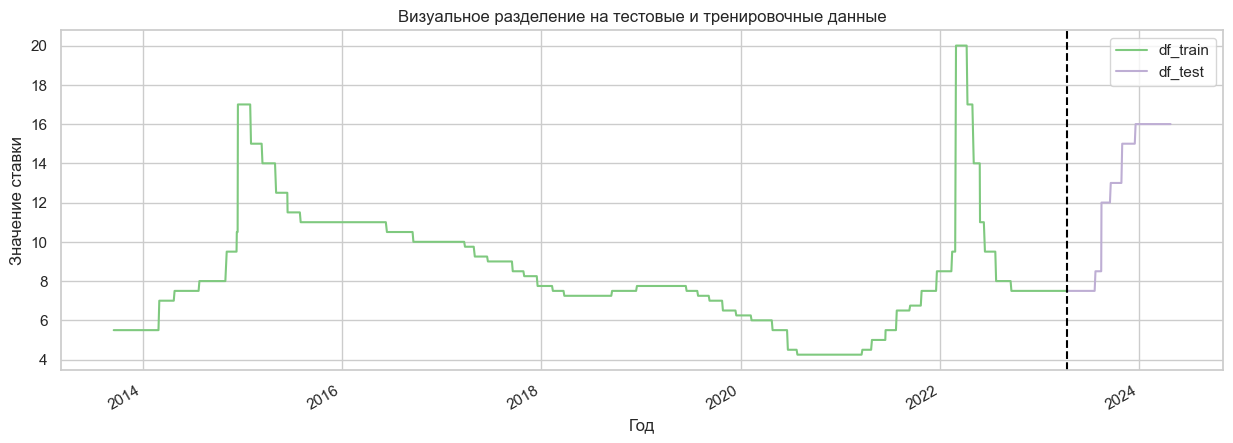

In [15]:
#отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

# Baseline Prophet

In [16]:
# обучение модели на train
model = Prophet()
model.fit(df_train)

00:17:54 - cmdstanpy - INFO - Chain [1] start processing
00:17:55 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = model.make_future_dataframe(periods=pred_days, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2639,2023-12-27,11.898248,9.446091,14.179722
2640,2023-12-28,11.875259,9.697306,14.109432
2641,2023-12-29,11.863206,9.390985,14.459900
2642,2023-12-30,12.650909,10.280765,15.001915
2643,2023-12-31,12.641831,10.243919,15.191529


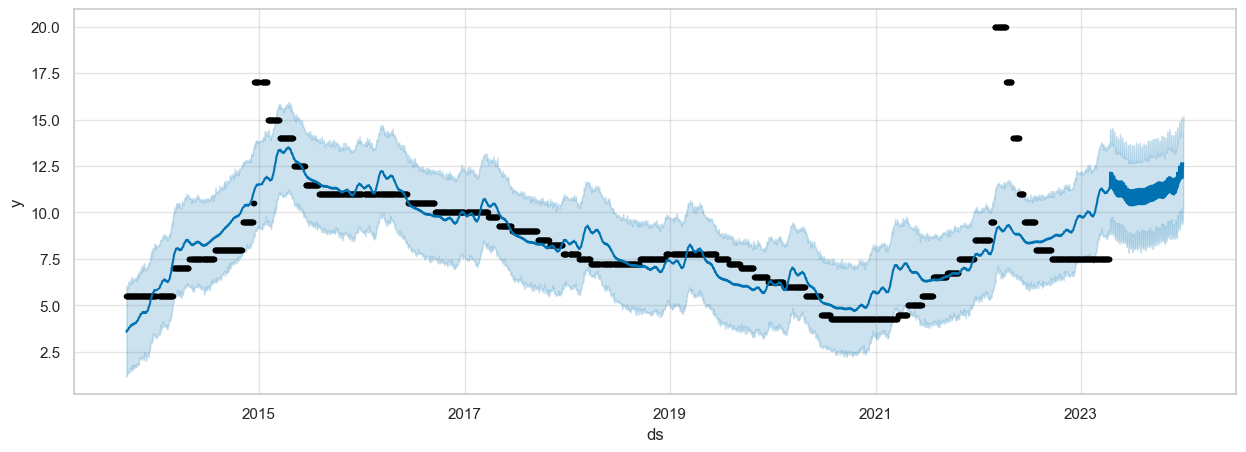

In [18]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

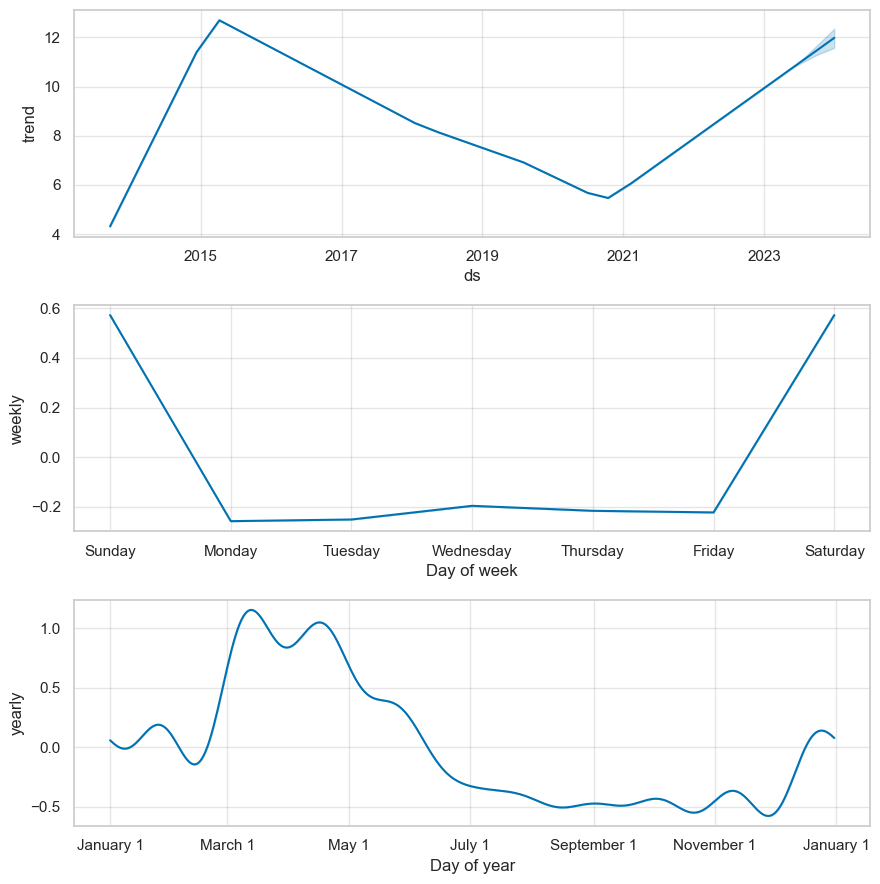

In [19]:
# Смотрим тренд, годовые и сезонные признаки
fig = model.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [20]:
df_test_forecast = model.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-18,13.421166,10.861879,16.052677
260,2024-04-19,13.409765,10.909602,15.967486
261,2024-04-22,13.335546,10.921482,15.749715
262,2024-04-23,13.321968,10.881169,15.903055
263,2024-04-24,13.353763,10.976029,15.758591


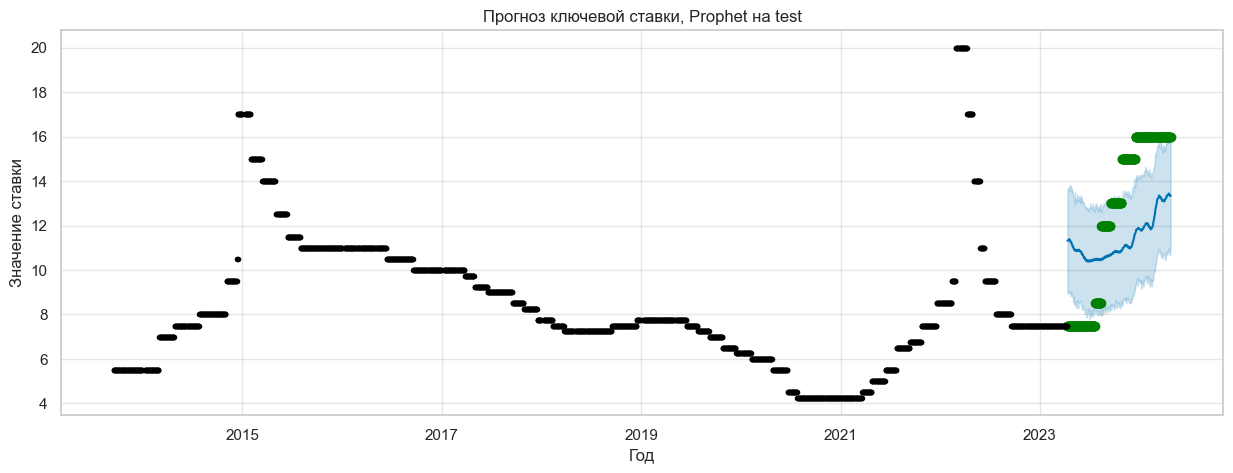

In [21]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model.predict(df_test)
fig = model.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

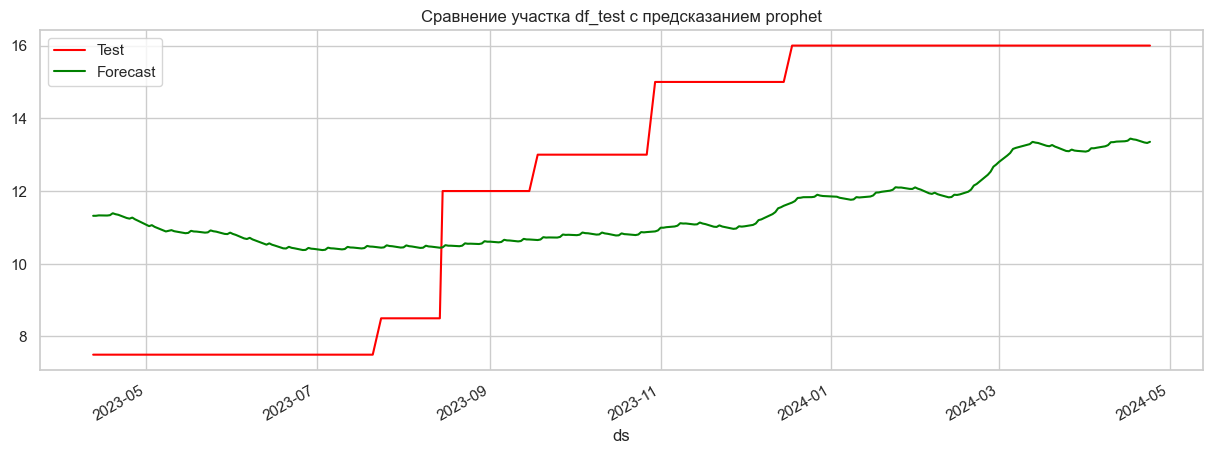

In [22]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [23]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,3.05631,0.267402,10.078461,3.174659


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [24]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [25]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

00:18:01 - cmdstanpy - INFO - Chain [1] start processing
00:18:01 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2639,2023-12-27,11.980862,9.620193,14.663517
2640,2023-12-28,11.961882,9.726275,14.484237
2641,2023-12-29,11.964416,9.461444,14.401976
2642,2023-12-30,12.754195,10.367963,15.158002
2643,2023-12-31,12.752185,10.395031,15.051160


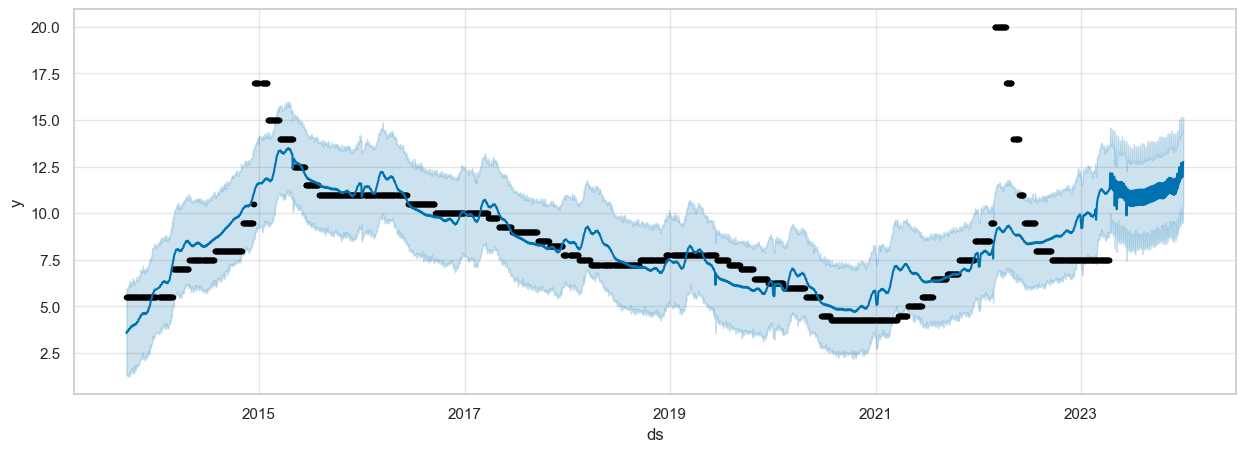

In [27]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

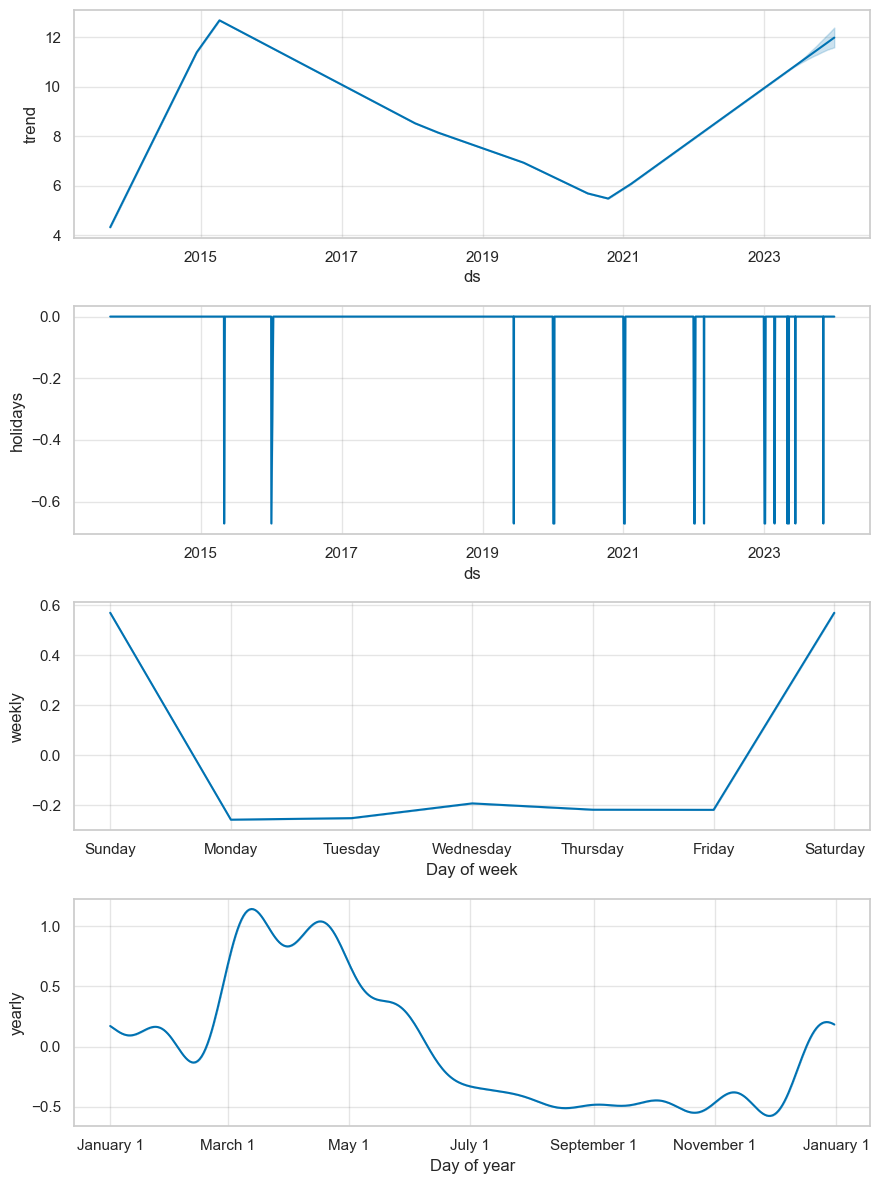

In [28]:
# смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

In [29]:
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-18,13.423051,10.912778,15.958630
260,2024-04-19,13.419432,10.953076,15.846528
261,2024-04-22,13.346278,10.819755,15.935159
262,2024-04-23,13.333713,11.091276,15.792144
263,2024-04-24,13.370815,10.809927,15.925774


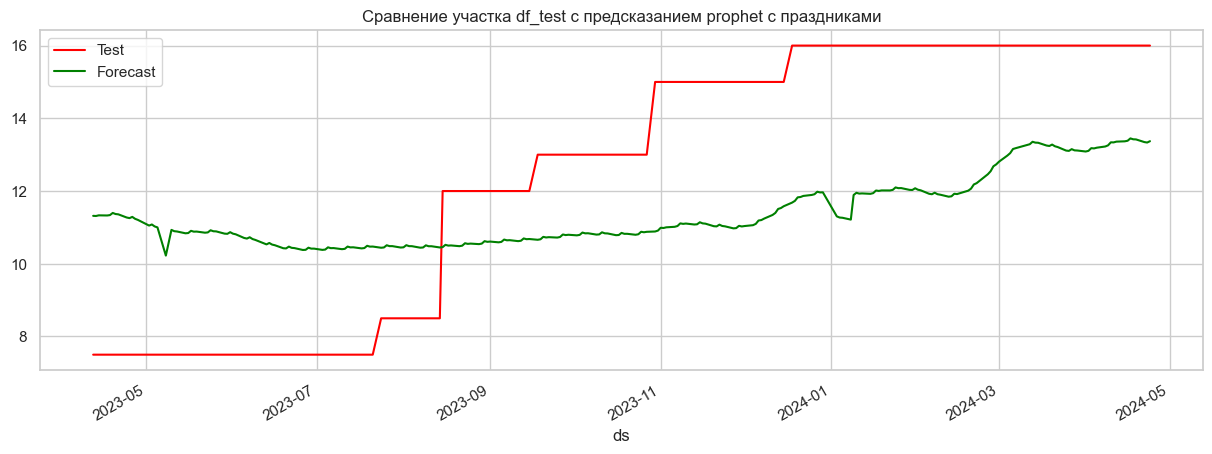

In [30]:
# Сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [31]:
# сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,3.056310,0.267402,10.078461,3.174659
0,Prophet_with_holidays,3.057987,0.267445,10.104276,3.178722


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [32]:
# создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [33]:
"""Обучение тестовой модели по сетке параметров"""
# Создаем пустой DataFrame для сохранения метрик
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    #print(p)
#for p in grid:
#    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #daily_seasonality = p['daily_seasonality'],
        #weekly_seasonality = p['weekly_seasonality'],
        #yearly_seasonality = p['yearly_seasonality'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)



  0%|          | 0/672 [00:00<?, ?it/s]

00:18:06 - cmdstanpy - INFO - Chain [1] start processing
00:18:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:00<09:43,  1.15it/s]00:18:06 - cmdstanpy - INFO - Chain [1] start processing
00:18:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:01<09:02,  1.23it/s]00:18:07 - cmdstanpy - INFO - Chain [1] start processing
00:18:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:02<09:14,  1.21it/s]00:18:08 - cmdstanpy - INFO - Chain [1] start processing
00:18:08 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:03<08:39,  1.29it/s]00:18:09 - cmdstanpy - INFO - Chain [1] start processing
00:18:09 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:04<09:48,  1.13it/s]00:18:10 - cmdstanpy - INFO - Chain [1] start processing
00:18:10 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:05<09:46,  1.14it/s]00:18:11 - cmdstanpy - INFO - Chain [1] 

In [34]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [35]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.607549,0.384790,45.989707,6.781571,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.696872,0.393241,46.973131,6.853695,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,5.680826,0.392583,46.623359,6.828130,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,5.815862,0.401626,48.876601,6.991180,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.448923,0.375329,43.199274,6.572615,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.849830,1.045347,308.899815,17.575546,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,4.221407,0.329608,21.163509,4.600381,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,4.297321,0.335523,21.931913,4.683152,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,4.316333,0.335669,22.245322,4.716495,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [36]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.567207,0.307330,14.069809,3.750974,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
1,Prophet_with_grid,3.567207,0.307330,14.069809,3.750974,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
2,Prophet_with_grid,3.567207,0.307330,14.069809,3.750974,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
3,Prophet_with_grid,3.567207,0.307330,14.069809,3.750974,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
4,Prophet_with_grid,3.569383,0.307163,14.116879,3.757244,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [38]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params


{'changepoint_prior_scale': 0.06,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [39]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

00:35:32 - cmdstanpy - INFO - Chain [1] start processing
00:35:32 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Вывод всех параметров модели Prophet
print(final_test_model.params)

OrderedDict([('lp__', array([[4391.77]])), ('k', array([[2.49279]])), ('m', array([[0.225559]])), ('delta', array([[ 3.04149e-08,  3.18378e-01,  1.10428e-09, -7.98046e-01,
        -2.74403e+00,  1.18443e-07, -1.03835e-07,  3.32740e-09,
         1.32918e-07,  1.43922e-08,  3.05082e-08, -4.69381e-08,
         3.38814e-07,  1.11242e-01,  2.50575e-01, -6.96383e-08,
         8.53713e-08, -5.63048e-07, -4.40714e-01,  1.01369e-08,
         8.17942e-08,  4.37500e-01,  1.34127e+00,  3.18115e-02,
        -7.69047e-04]])), ('sigma_obs', array([[0.0914997]])), ('beta', array([[ 0.0334856 ,  0.00207915, -0.00202264, -0.0109002 , -0.00496577,
         0.00413833, -0.00118053,  0.00483975,  0.00049529,  0.00467565,
         0.00231361,  0.00206129,  0.0011905 ,  0.00079772, -0.00029979,
        -0.00314185, -0.00513868, -0.00215052, -0.00312787,  0.00050895,
         0.0134376 , -0.00960136, -0.0122519 , -0.00250887,  0.00179161,
         0.00334449]])), ('trend', array([[0.225559, 0.226273, 0.226987

In [41]:
# Прогнозировние после обучния на луших параметрах
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2639,2023-12-27,11.959087,9.530816,14.464031
2640,2023-12-28,11.936832,9.598039,14.455943
2641,2023-12-29,11.924861,9.458757,14.383908
2642,2023-12-30,12.569536,10.260499,14.894825
2643,2023-12-31,12.560707,10.211906,14.991186


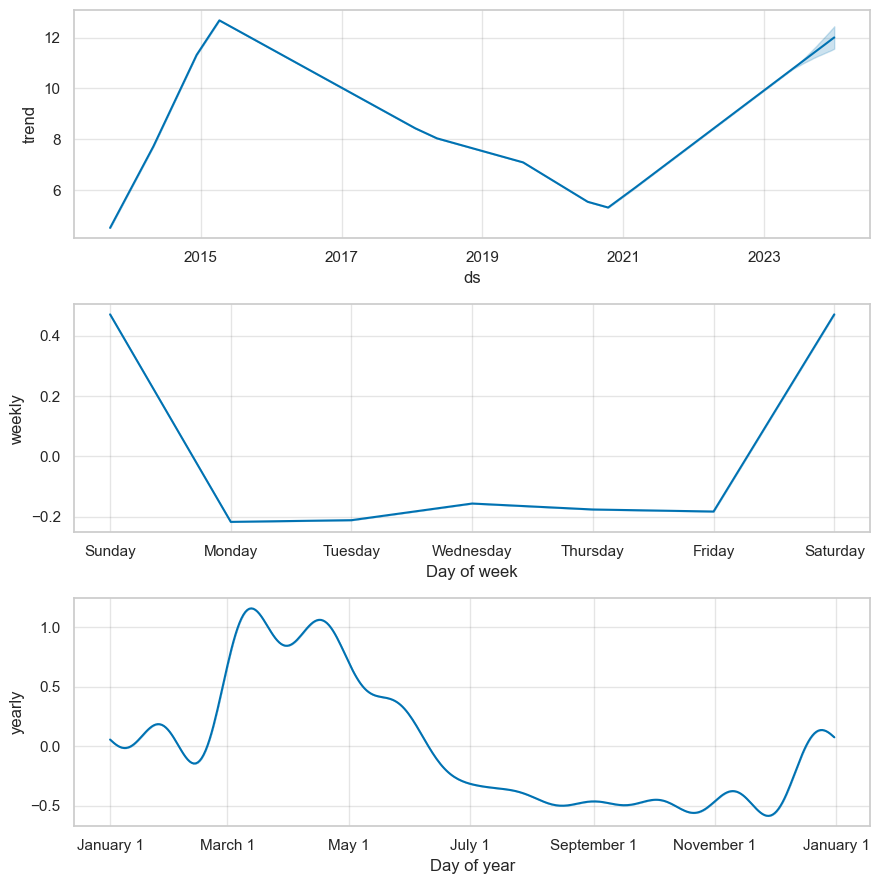

In [42]:
# Просмотр компонентов
fig = final_test_model.plot_components(forecast)

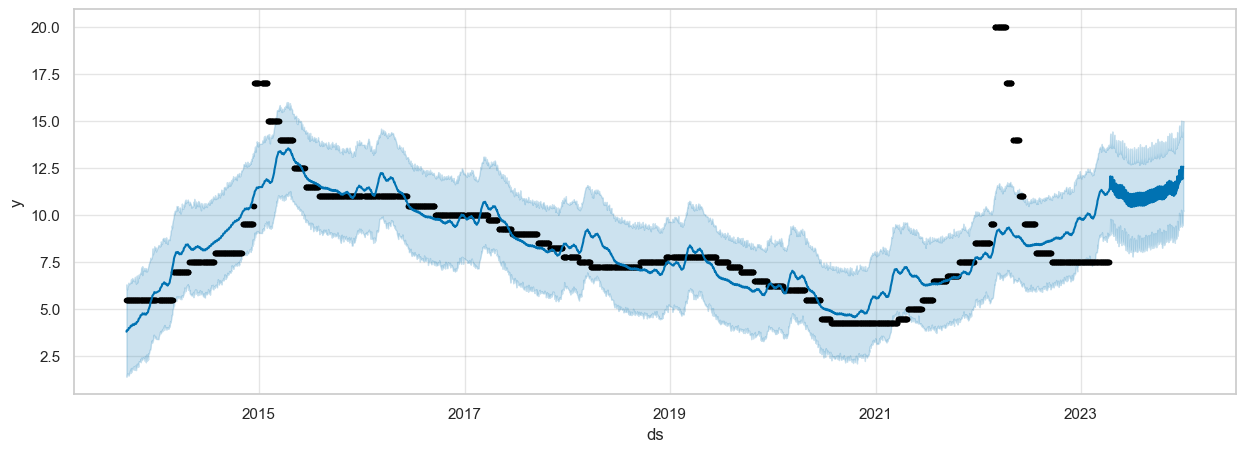

In [43]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

In [44]:
# Просмотр df данных после предсказания на лучших параметрах
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-18,13.511302,10.981092,16.025204
260,2024-04-19,13.500260,10.868188,15.901110
261,2024-04-22,13.428756,10.824477,15.917539
262,2024-04-23,13.414638,10.892054,15.968552
263,2024-04-24,13.446949,10.811398,15.815618


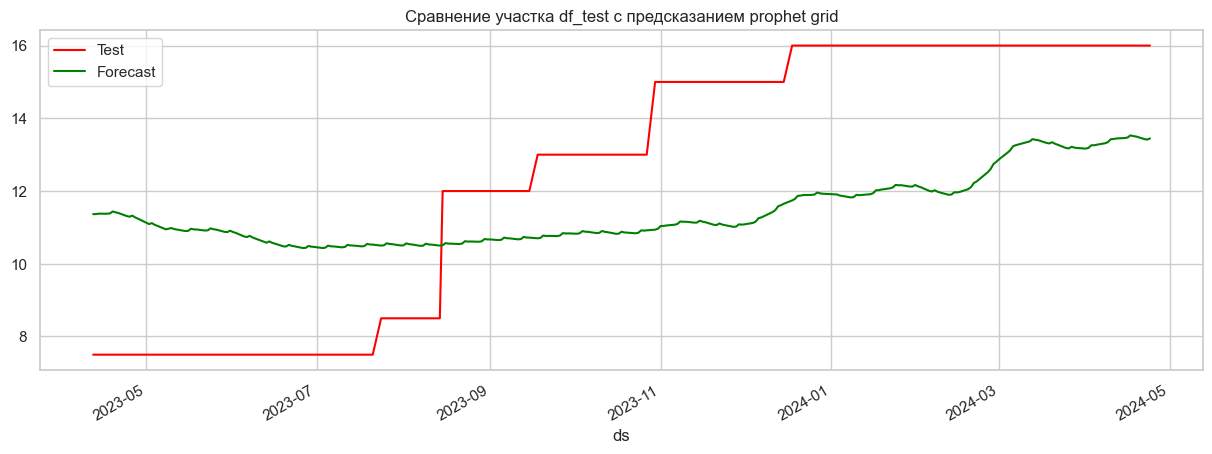

In [45]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [46]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,3.056310,0.267402,10.078461,3.174659
0,Prophet_with_holidays,3.057987,0.267445,10.104276,3.178722
0,Prophet_with_grid,3.032899,0.266946,9.934756,3.151945


In [47]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train.to_csv('../data/df_train.csv', index=False)

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test.to_csv('../data/df_test.csv', index=False)


In [48]:
# Сохранение модели в JSON файл
with open('../backend/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))